# Model Testing Summary Across Edge Types

This notebook aggregates and analyzes the results from **Notebook 4** (model testing) across all 24 edge types.

## Purpose

- Summarize ML model performance (RF, LogReg, PolyLogReg, Simple NN) across all edge types
- Identify best-performing models by edge type
- Analyze relationship between graph characteristics and model performance
- Provide recommendations for model selection based on graph properties

## Workflow

1. Load results from all edge types
2. Aggregate performance metrics
3. Analyze by graph characteristics (density, size, degree distributions)
4. Create visualizations and summary tables
5. Generate recommendations

In [1]:
# Papermill parameters (optional)
edge_types = None  # None = use all 24 edge types, or provide list like ['CtD', 'AeG']

In [2]:
import sys

from pathlib import Path

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import json

import scipy.sparse as sp

from typing import Dict, List, Tuple

import warnings

warnings.filterwarnings('ignore')



# Setup paths

repo_dir = Path.cwd().parent

data_dir = repo_dir / 'data'

results_dir = repo_dir / 'results' / 'model_comparison'

summary_dir = repo_dir / 'results' / 'model_comparison_summary'

summary_dir.mkdir(parents=True, exist_ok=True)



print(f"Repository directory: {repo_dir}")

print(f"Results directory: {results_dir}")

print(f"Summary output directory: {summary_dir}")



# Set plot style

sns.set_style('whitegrid')

plt.rcParams['figure.dpi'] = 100

Repository directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability
Results directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison
Summary output directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary


## 1. Discover and Load Results

In [3]:
# Default edge types (all 24)
DEFAULT_EDGE_TYPES = [
    "AdG", "AeG", "AuG", "CbG", "CcSE", "CdG", "CpD", "CrC", "CtD", "CuG",
    "DaG", "DdG", "DlA", "DpS", "DrD", "DuG", "GcG", "GiG", "GpBP", "GpCC",
    "GpMF", "GpPW", "Gr>G", "PCiC"
]

# Use provided edge_types or default to all
if edge_types is None:
    edge_types = DEFAULT_EDGE_TYPES

print(f"Analyzing {len(edge_types)} edge types")

def load_edge_type_results(edge_type: str) -> Dict:
    """Load all result files for a given edge type."""
    edge_results_dir = results_dir / f"{edge_type}_results"
    
    if not edge_results_dir.exists():
        return None
    
    results = {'edge_type': edge_type}
    
    # Load model comparison metrics
    comparison_file = edge_results_dir / 'model_comparison.csv'
    if comparison_file.exists():
        results['model_comparison'] = pd.read_csv(comparison_file)
    
    # Load analytical comparison
    analytical_file = edge_results_dir / 'models_vs_analytical_comparison.csv'
    if analytical_file.exists():
        results['analytical_comparison'] = pd.read_csv(analytical_file)
    
    # Load empirical comparison
    empirical_file = edge_results_dir / 'test_vs_empirical_comparison.csv'
    if empirical_file.exists():
        results['empirical_comparison'] = pd.read_csv(empirical_file)
    

    # Load analytical vs empirical comparison
    analytical_empirical_file = edge_results_dir / 'analytical_vs_empirical_comparison.csv'
    if analytical_empirical_file.exists():
        results['analytical_vs_empirical'] = pd.read_csv(analytical_empirical_file)
    return results

# Load all results
all_results = {}
successful_loads = 0
failed_loads = []

for edge_type in edge_types:
    result = load_edge_type_results(edge_type)
    if result is not None:
        all_results[edge_type] = result
        successful_loads += 1
    else:
        failed_loads.append(edge_type)

print(f"\nSuccessfully loaded results for {successful_loads} edge types")
if failed_loads:
    print(f"Failed to load results for {len(failed_loads)} edge types: {failed_loads}")

Analyzing 24 edge types

Successfully loaded results for 24 edge types


## 2. Load Graph Characteristics

In [4]:
def get_graph_characteristics(edge_type: str) -> Dict:
    """Extract graph characteristics from edge matrix."""
    edge_file = data_dir / 'permutations' / '000.hetmat' / 'edges' / f"{edge_type}.sparse.npz"
    
    if not edge_file.exists():
        return None
    
    # Load edge matrix
    edge_matrix = sp.load_npz(edge_file)
    n_sources, n_targets = edge_matrix.shape
    n_edges = edge_matrix.nnz
    
    # Calculate characteristics
    density = n_edges / (n_sources * n_targets)
    source_degrees = np.array(edge_matrix.sum(axis=1)).flatten()
    target_degrees = np.array(edge_matrix.sum(axis=0)).flatten()
    
    # Filter zero degrees
    source_degrees_nz = source_degrees[source_degrees > 0]
    target_degrees_nz = target_degrees[target_degrees > 0]
    
    return {
        'edge_type': edge_type,
        'n_sources': n_sources,
        'n_targets': n_targets,
        'n_edges': n_edges,
        'density': density,
        'mean_source_degree': source_degrees_nz.mean() if len(source_degrees_nz) > 0 else 0,
        'mean_target_degree': target_degrees_nz.mean() if len(target_degrees_nz) > 0 else 0,
        'max_source_degree': source_degrees.max(),
        'max_target_degree': target_degrees.max(),
        'n_sources_nz': len(source_degrees_nz),
        'n_targets_nz': len(target_degrees_nz)
    }

# Load graph characteristics
graph_chars = []
for edge_type in all_results.keys():
    chars = get_graph_characteristics(edge_type)
    if chars is not None:
        graph_chars.append(chars)

graph_chars_df = pd.DataFrame(graph_chars)
print(f"\nLoaded graph characteristics for {len(graph_chars_df)} edge types")
print(f"\nDensity range: {graph_chars_df['density'].min():.6f} - {graph_chars_df['density'].max():.6f}")
print(f"Edge count range: {graph_chars_df['n_edges'].min()} - {graph_chars_df['n_edges'].max()}")


Loaded graph characteristics for 24 edge types

Density range: 0.000281 - 0.065403
Edge count range: 390 - 559504


## 3. Aggregate Model Performance Metrics

In [5]:
# Aggregate model comparison metrics across all edge types
model_performance = []

for edge_type, results in all_results.items():
    if 'model_comparison' not in results:
        continue
    
    df = results['model_comparison'].copy()
    df['edge_type'] = edge_type
    model_performance.append(df)

if model_performance:
    model_perf_df = pd.concat(model_performance, ignore_index=True)
    print(f"Aggregated performance metrics: {len(model_perf_df)} records")
    print(f"Models: {model_perf_df['Model'].unique().tolist()}")
else:
    print("No model performance data available")
    model_perf_df = pd.DataFrame()

Aggregated performance metrics: 88 records
Models: ['Simple NN', 'Polynomial Logistic Regression', 'Random Forest', 'Logistic Regression']


In [6]:
# Merge with graph characteristics
if not model_perf_df.empty:
    model_perf_df = model_perf_df.merge(graph_chars_df, on='edge_type', how='left')
    
    # Categorize by density
    model_perf_df['density_category'] = pd.cut(
        model_perf_df['density'],
        bins=[0, 0.01, 0.03, 0.05, 1.0],
        labels=['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)']
    )
    
    print("\nDensity category distribution:")
    print(model_perf_df.groupby('density_category')['edge_type'].nunique())


Density category distribution:
density_category
Very Sparse (<1%)    15
Sparse (1-3%)         3
Medium (3-5%)         0
Dense (>5%)           4
Name: edge_type, dtype: int64


## 4. Best Model Analysis

In [7]:
# Identify best model for each edge type by different metrics
best_models = []

for edge_type in model_perf_df['edge_type'].unique():
    edge_data = model_perf_df[model_perf_df['edge_type'] == edge_type]
    
    best_model_entry = {
        'edge_type': edge_type,
        'best_auc': edge_data.loc[edge_data['AUC'].idxmax(), 'Model'],
        'best_correlation': edge_data.loc[edge_data['Correlation'].idxmax(), 'Model'],
        'best_f1': edge_data.loc[edge_data['F1 Score'].idxmax(), 'Model'],
        'best_rmse': edge_data.loc[edge_data['RMSE'].idxmin(), 'Model'],
        'density': edge_data.iloc[0]['density'],
        'n_edges': edge_data.iloc[0]['n_edges']
    }
    best_models.append(best_model_entry)

best_models_df = pd.DataFrame(best_models)

print("\nBest models by metric:")
print("\nAUC:")
print(best_models_df['best_auc'].value_counts())
print("\nCorrelation:")
print(best_models_df['best_correlation'].value_counts())
print("\nF1 Score:")
print(best_models_df['best_f1'].value_counts())


Best models by metric:

AUC:
best_auc
Simple NN                         15
Polynomial Logistic Regression     7
Name: count, dtype: int64

Correlation:
best_correlation
Random Forest                     11
Polynomial Logistic Regression    10
Logistic Regression                1
Name: count, dtype: int64

F1 Score:
best_f1
Logistic Regression               9
Polynomial Logistic Regression    8
Random Forest                     4
Simple NN                         1
Name: count, dtype: int64


## 5. Model Performance Statistics

In [8]:
# Calculate average performance by model
if not model_perf_df.empty:
    model_stats = model_perf_df.groupby('Model').agg({
        'AUC': ['mean', 'std', 'min', 'max'],
        'Accuracy': ['mean', 'std', 'min', 'max'],
        'F1 Score': ['mean', 'std', 'min', 'max'],
        'Correlation': ['mean', 'std', 'min', 'max'],
        'RMSE': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE STATISTICS ACROSS ALL EDGE TYPES")
    print("="*80)
    print(model_stats)
    
    # Save to CSV
    model_stats.to_csv(summary_dir / 'model_statistics_summary.csv')
    print(f"\nSaved model statistics to {summary_dir / 'model_statistics_summary.csv'}")


MODEL PERFORMANCE STATISTICS ACROSS ALL EDGE TYPES
                                   AUC                         Accuracy  \
                                  mean     std     min     max     mean   
Model                                                                     
Logistic Regression             0.8396  0.0766  0.7055  0.9644   0.9268   
Polynomial Logistic Regression  0.8453  0.0777  0.7077  0.9709   0.9281   
Random Forest                   0.8454  0.0817  0.7066  0.9725   0.9281   
Simple NN                       0.8482  0.0843  0.7060  0.9743   0.9082   

                                                       F1 Score          \
                                   std     min     max     mean     std   
Model                                                                     
Logistic Regression             0.0352  0.8293  0.9596   0.2771  0.1797   
Polynomial Logistic Regression  0.0363  0.8303  0.9628   0.2889  0.2151   
Random Forest                   0.0367  0.8298 

## 6. Visualizations

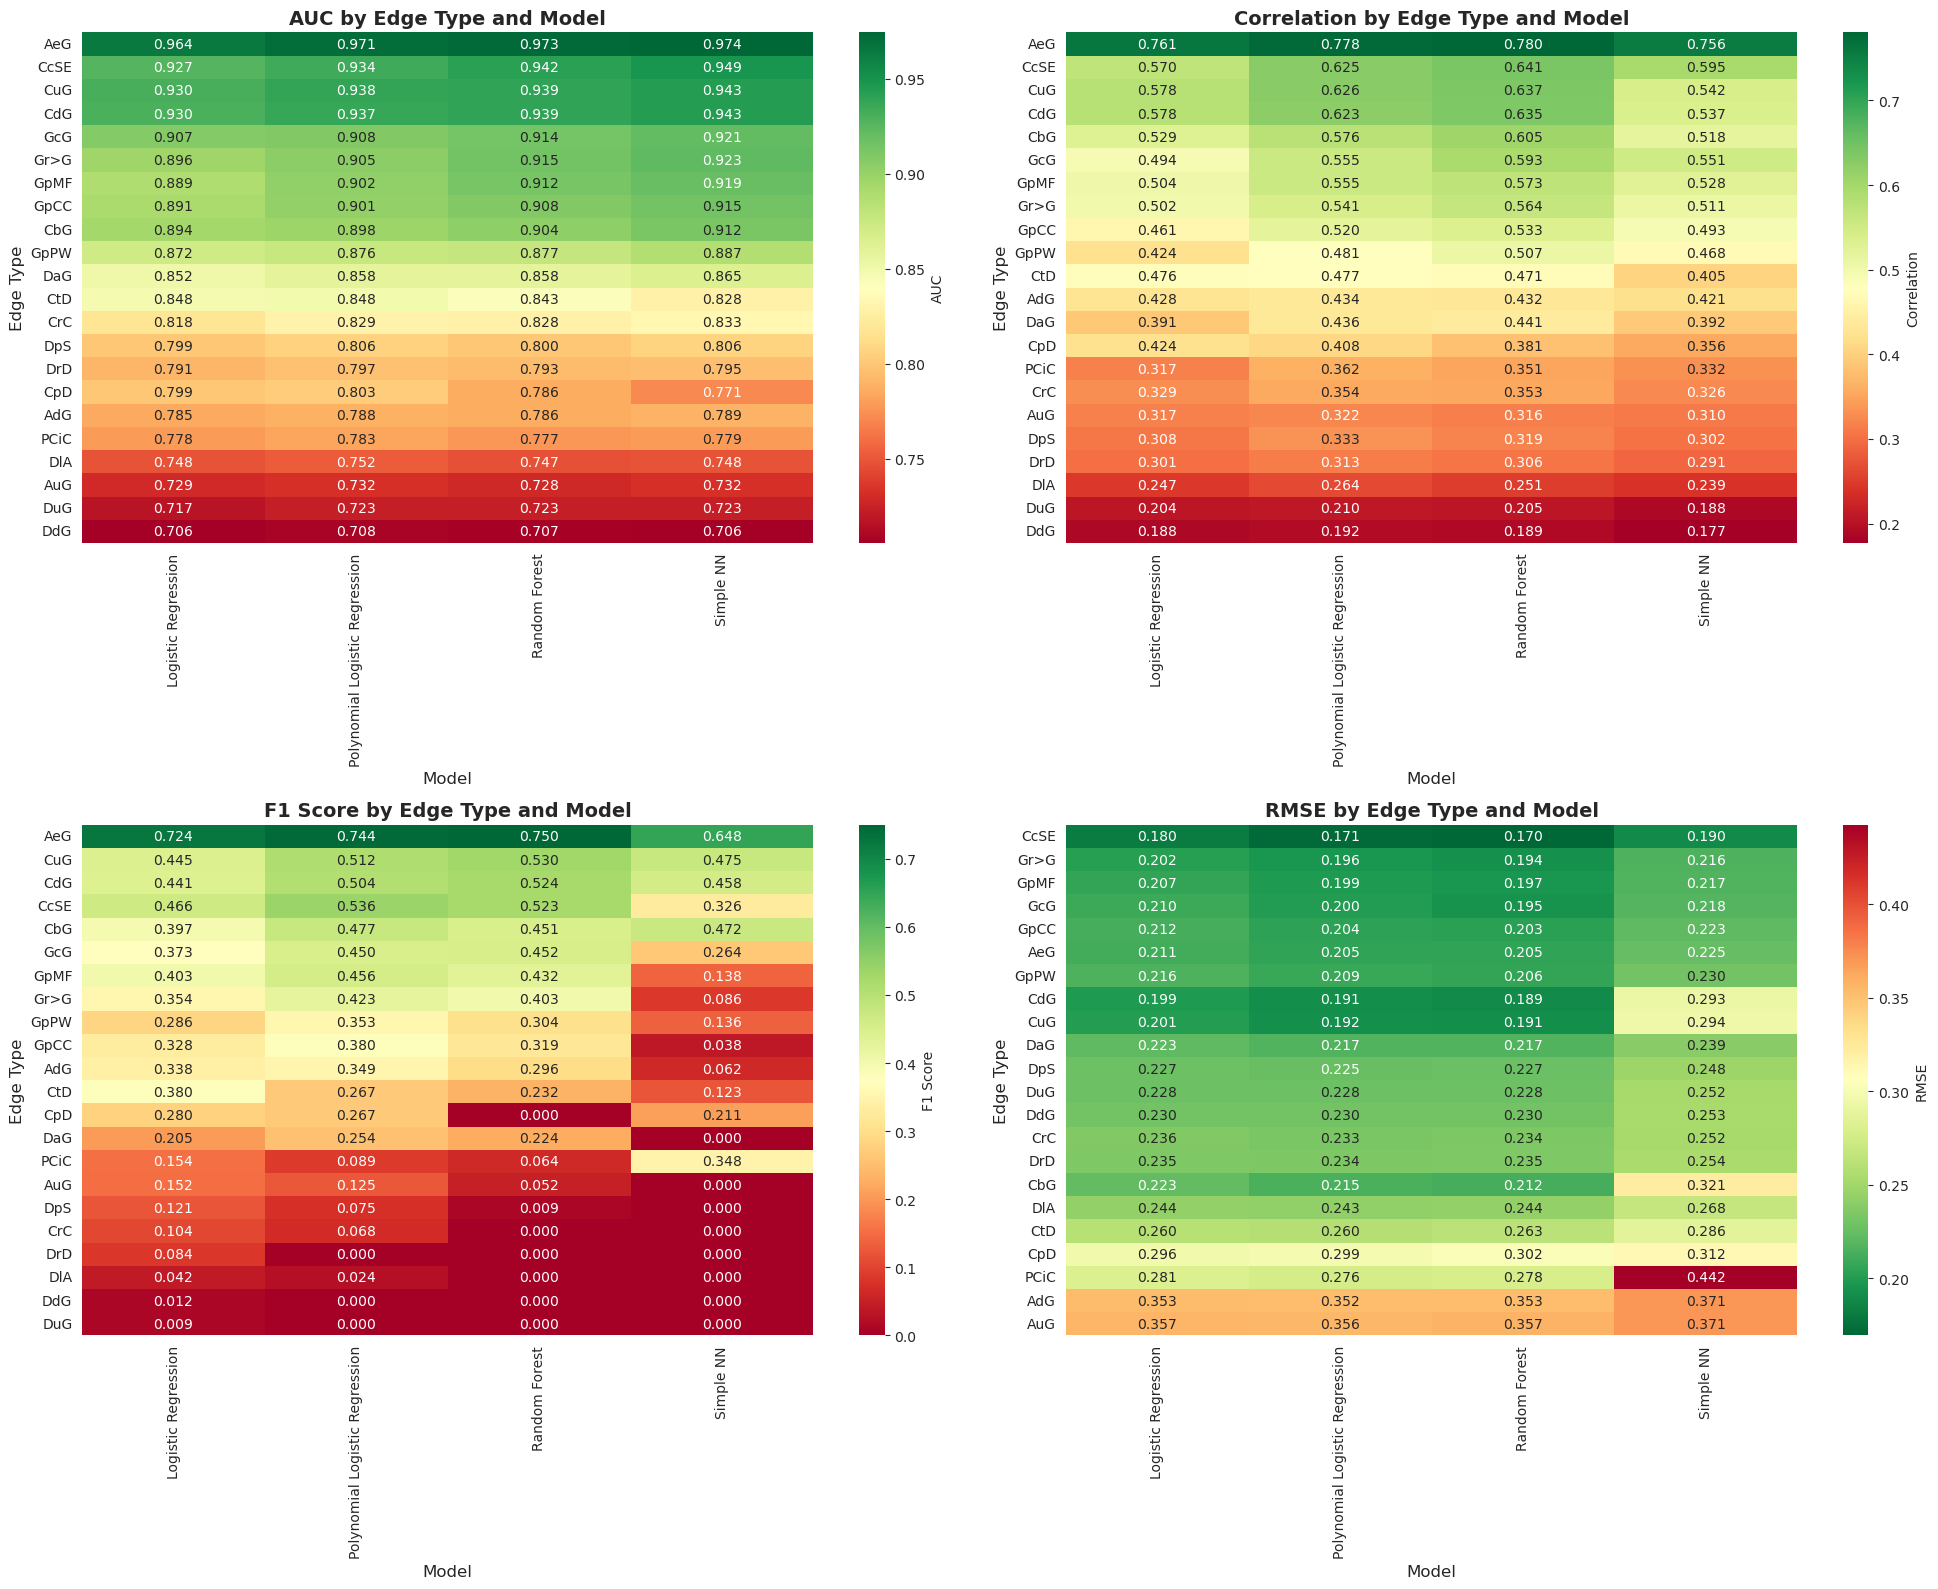

Saved performance heatmaps


In [9]:
# 1. Performance heatmap by edge type and model
if not model_perf_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    metrics = ['AUC', 'Correlation', 'F1 Score', 'RMSE']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Pivot for heatmap
        pivot = model_perf_df.pivot_table(
            values=metric, 
            index='edge_type', 
            columns='Model',
            aggfunc='mean'
        )
        
        # Sort by mean performance
        pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=(metric=='RMSE')).index]
        
        # Create heatmap
        sns.heatmap(
            pivot, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn' if metric != 'RMSE' else 'RdYlGn_r',
            ax=ax,
            cbar_kws={'label': metric}
        )
        ax.set_title(f'{metric} by Edge Type and Model', fontsize=14, fontweight='bold')
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Edge Type', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(summary_dir / 'performance_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved performance heatmaps")

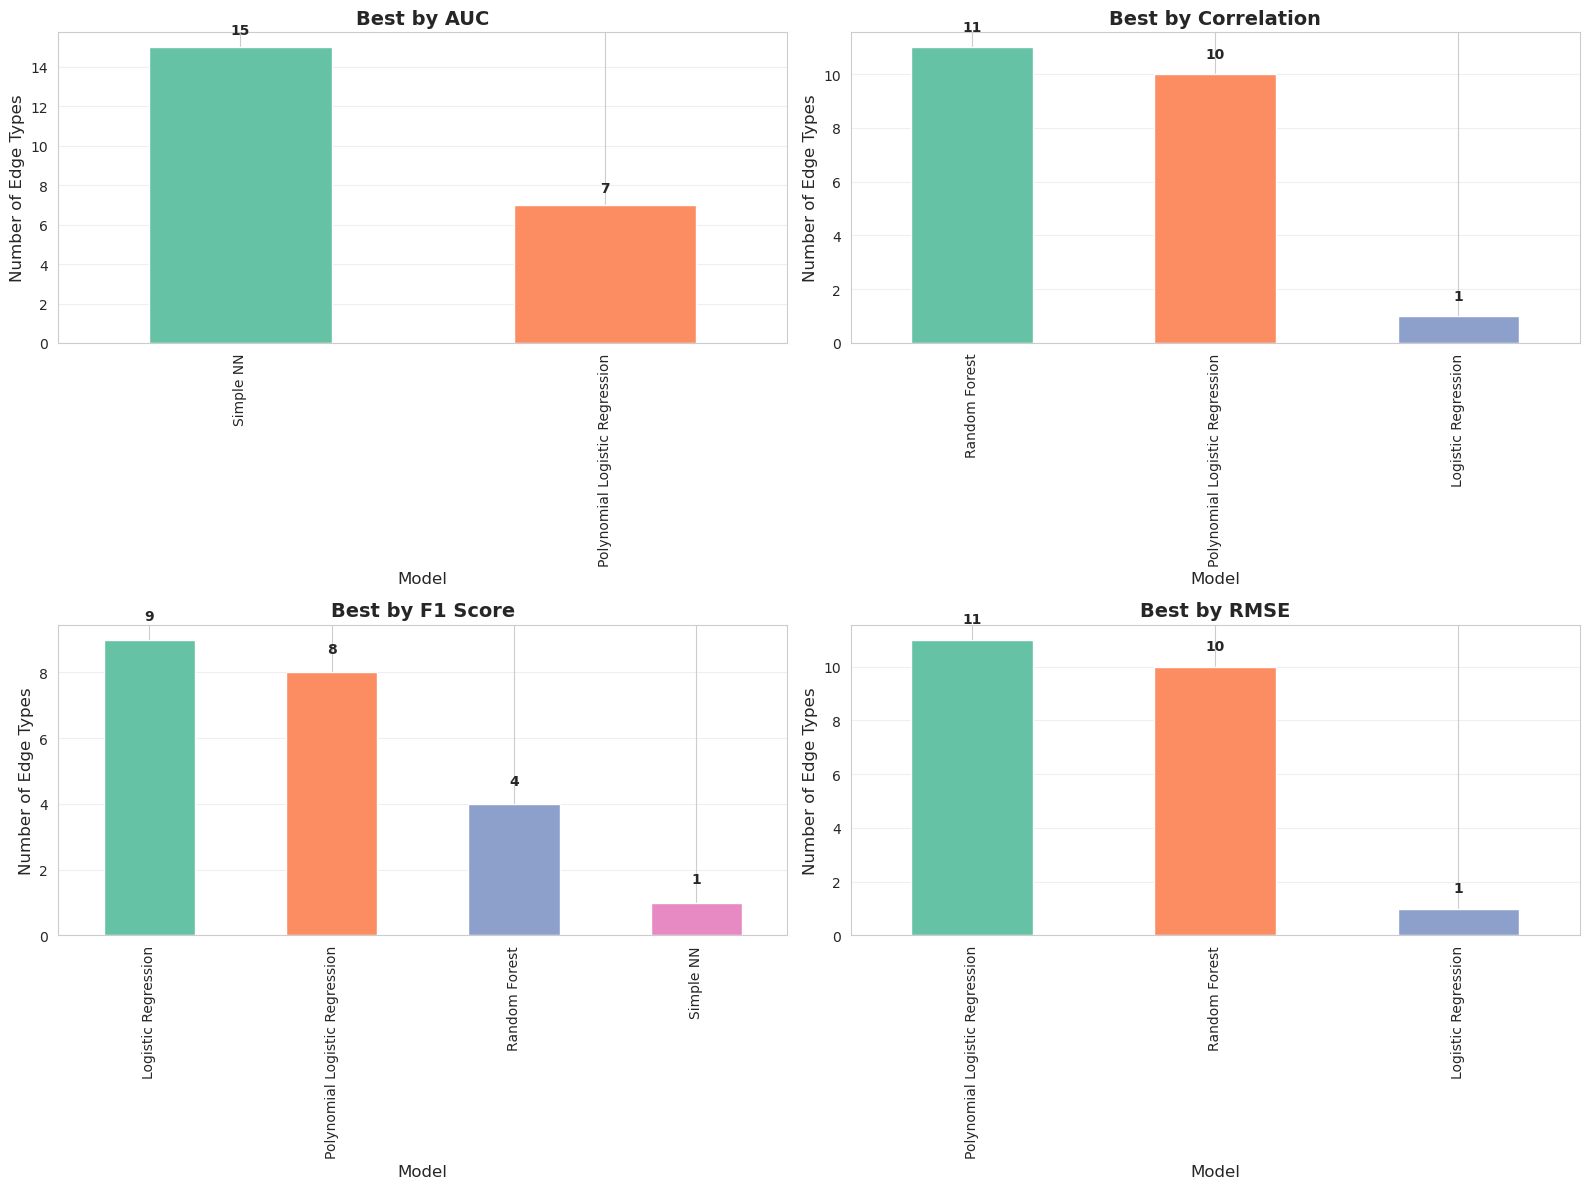

Saved best model distribution


In [10]:
# 2. Best model distribution
if not best_models_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics = ['best_auc', 'best_correlation', 'best_f1', 'best_rmse']
    titles = ['Best by AUC', 'Best by Correlation', 'Best by F1 Score', 'Best by RMSE']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        counts = best_models_df[metric].value_counts()
        counts.plot(kind='bar', ax=ax, color=sns.color_palette('Set2', len(counts)))
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Model', fontsize=12)
        ax.set_ylabel('Number of Edge Types', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Add count labels on bars
        for i, v in enumerate(counts.values):
            ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(summary_dir / 'best_model_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved best model distribution")

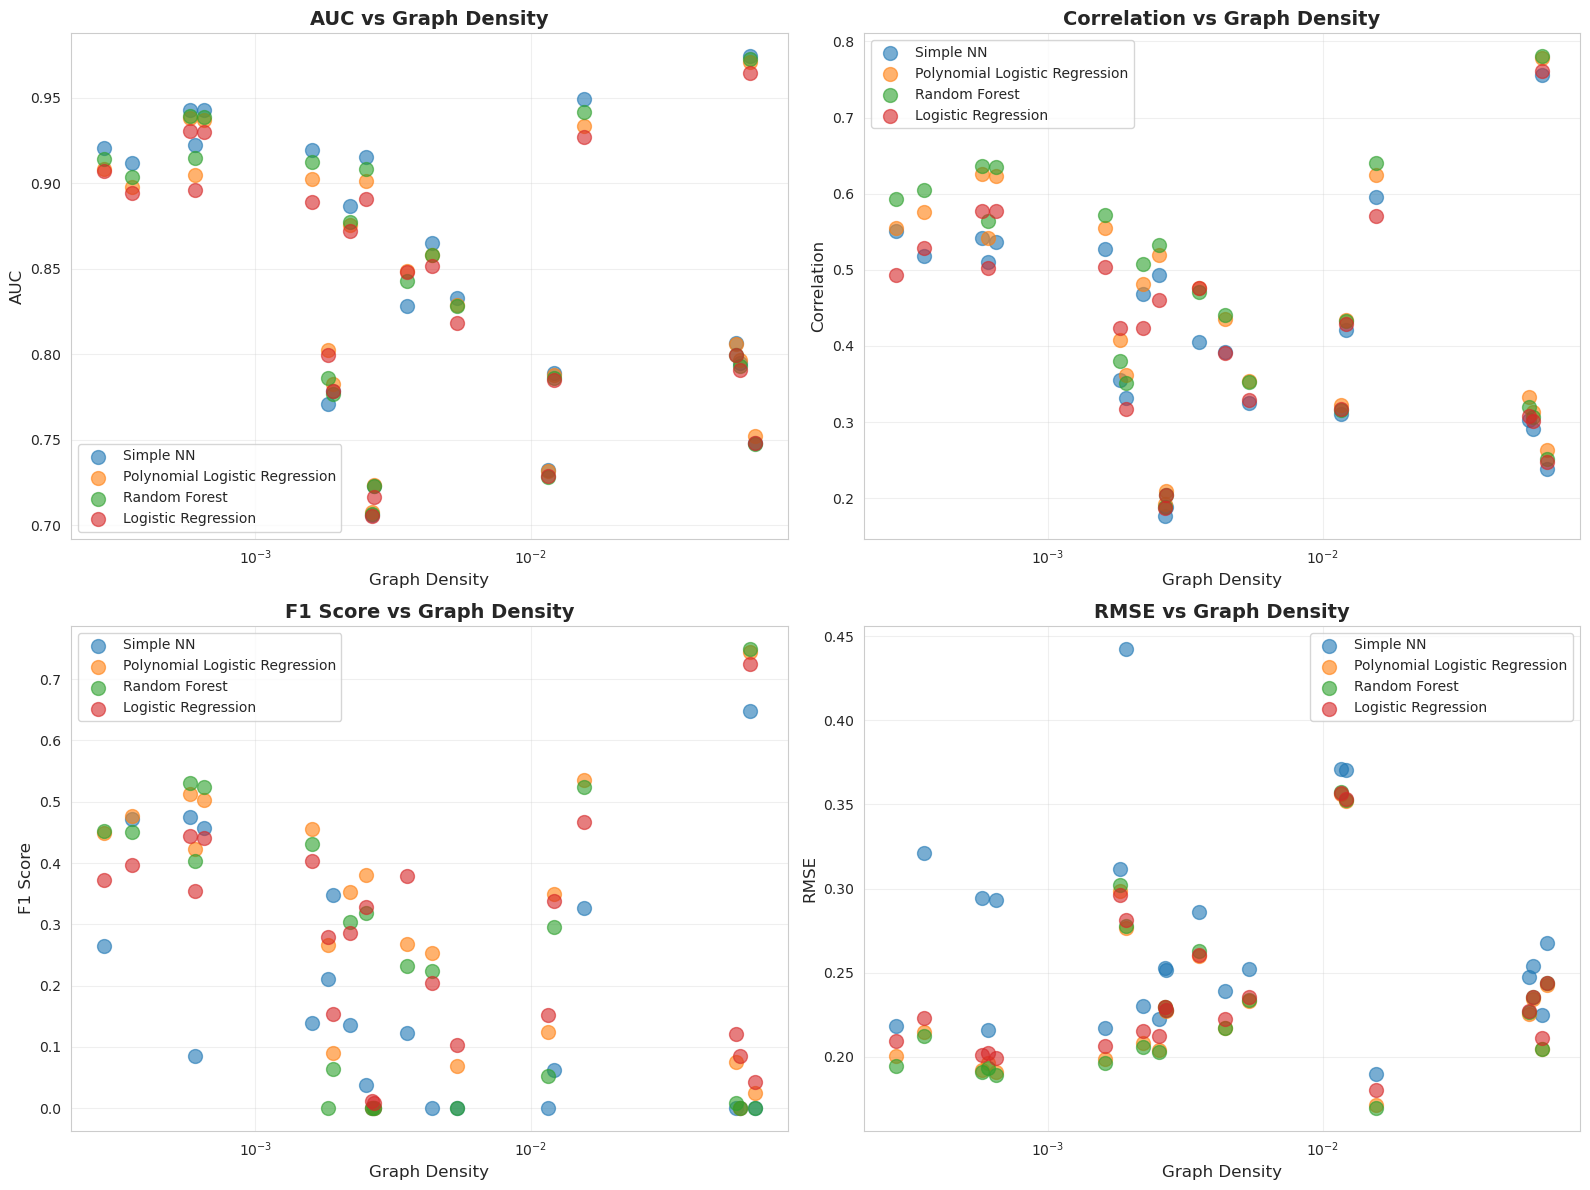

Saved performance vs density plots


In [11]:
# 3. Performance vs Graph Density
if not model_perf_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics = ['AUC', 'Correlation', 'F1 Score', 'RMSE']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        for model in model_perf_df['Model'].unique():
            model_data = model_perf_df[model_perf_df['Model'] == model]
            ax.scatter(
                model_data['density'], 
                model_data[metric],
                label=model,
                alpha=0.6,
                s=100
            )
        
        ax.set_xlabel('Graph Density', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'{metric} vs Graph Density', fontsize=14, fontweight='bold')
        ax.set_xscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(summary_dir / 'performance_vs_density.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved performance vs density plots")

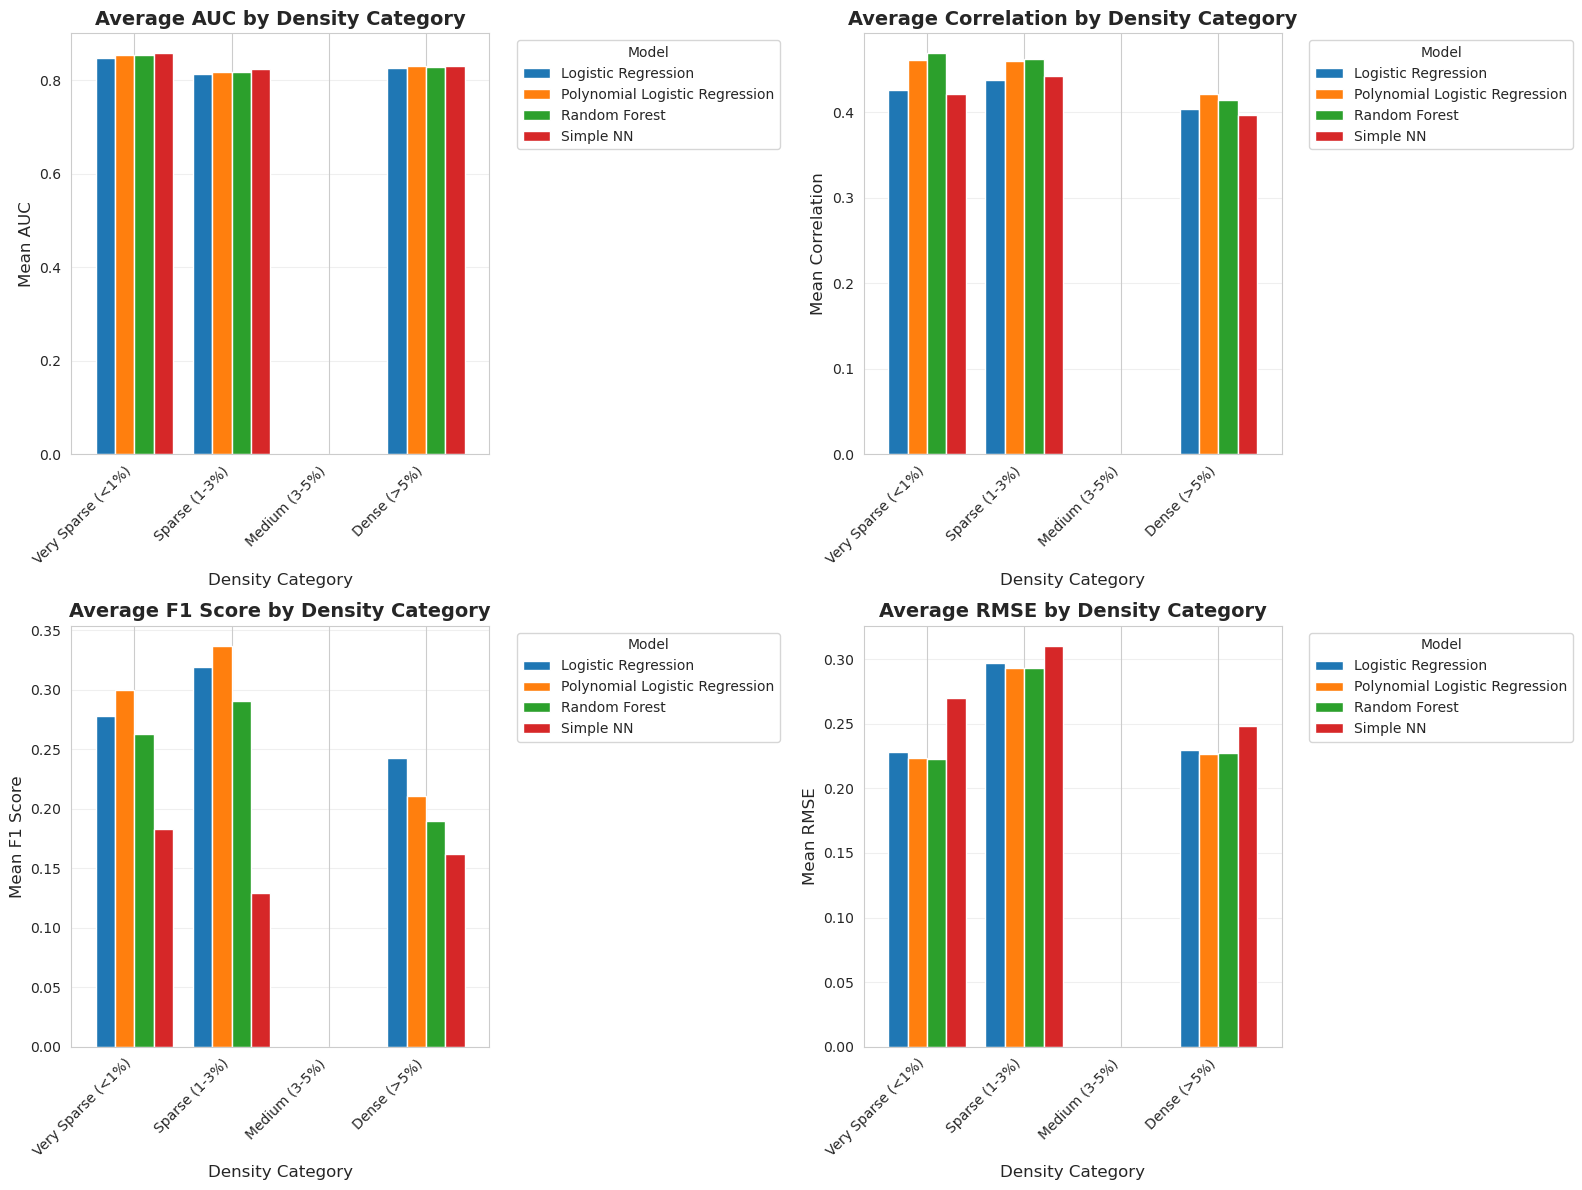

Saved performance by density category


In [12]:
# 4. Average performance by density category
if not model_perf_df.empty and 'density_category' in model_perf_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics = ['AUC', 'Correlation', 'F1 Score', 'RMSE']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Prepare data for grouped bar chart
        grouped = model_perf_df.groupby(['density_category', 'Model'])[metric].mean().unstack()
        
        grouped.plot(kind='bar', ax=ax, width=0.8)
        
        ax.set_title(f'Average {metric} by Density Category', fontsize=14, fontweight='bold')
        ax.set_xlabel('Density Category', fontsize=12)
        ax.set_ylabel(f'Mean {metric}', fontsize=12)
        ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(axis='y', alpha=0.3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(summary_dir / 'performance_by_density_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved performance by density category")

## 7. Correlation with Analytical and Empirical

In [13]:
# Aggregate analytical and empirical comparisons
analytical_data = []
empirical_data = []

for edge_type, results in all_results.items():
    if 'analytical_comparison' in results:
        df = results['analytical_comparison'].copy()
        df['edge_type'] = edge_type
        analytical_data.append(df)
    
    if 'empirical_comparison' in results:
        df = results['empirical_comparison'].copy()
        df['edge_type'] = edge_type
        empirical_data.append(df)

if analytical_data:
    analytical_df = pd.concat(analytical_data, ignore_index=True)
    print(f"\nAnalytical comparison data: {len(analytical_df)} records")
else:
    analytical_df = pd.DataFrame()

if empirical_data:
    empirical_df = pd.concat(empirical_data, ignore_index=True)
    print(f"Empirical comparison data: {len(empirical_df)} records")
else:
    empirical_df = pd.DataFrame()

# Load analytical vs empirical comparison data
analytical_vs_empirical_data = []
for edge_type, results in all_results.items():
    if 'analytical_vs_empirical' in results:
        df = results['analytical_vs_empirical'].copy()
        df['edge_type'] = edge_type
        analytical_vs_empirical_data.append(df)

if analytical_vs_empirical_data:
    analytical_vs_empirical_df = pd.concat(analytical_vs_empirical_data, ignore_index=True)
    print(f"Analytical vs Empirical comparison data: {len(analytical_vs_empirical_df)} records")
else:
    analytical_vs_empirical_df = pd.DataFrame()


Analytical comparison data: 88 records
Empirical comparison data: 80 records


In [ ]:
# Merge density categories into analytical and empirical data
if not analytical_df.empty:
    analytical_df = analytical_df.merge(
        graph_chars_df[['edge_type', 'density']], 
        on='edge_type', 
        how='left'
    )
    analytical_df['density_category'] = pd.cut(
        analytical_df['density'],
        bins=[0, 0.01, 0.03, 0.05, 1.0],
        labels=['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)']
    )

if not empirical_df.empty:
    empirical_df = empirical_df.merge(
        graph_chars_df[['edge_type', 'density']], 
        on='edge_type', 
        how='left'
    )
    empirical_df['density_category'] = pd.cut(
        empirical_df['density'],
        bins=[0, 0.01, 0.03, 0.05, 1.0],
        labels=['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)']
    )

# Prepare analytical vs empirical data with density categories
if not analytical_vs_empirical_df.empty and 'density_category' not in analytical_vs_empirical_df.columns:
    analytical_vs_empirical_df = analytical_vs_empirical_df.merge(
        graph_chars_df[['edge_type', 'density']],
        on='edge_type',
        how='left'
    )
    analytical_vs_empirical_df['density_category'] = pd.cut(
        analytical_vs_empirical_df['density'],
        bins=[0, 0.01, 0.03, 0.05, 1.0],
        labels=['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)']
    )

# Plot correlation boxplots by density category
if not empirical_df.empty or not analytical_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Analytical correlation boxplot
    if not analytical_df.empty and 'density_category' in analytical_df.columns:
        # Prepare data for boxplot
        box_data_analytical = []
        box_positions_analytical = []

        models = sorted(analytical_df['Model'].unique())
        density_cats = sorted([cat for cat in analytical_df['density_category'].dropna().unique()],
                             key=lambda x: ['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)'].index(x))

        pos = 0
        tick_positions = []
        tick_labels = []

        for cat_idx, cat in enumerate(density_cats):
            cat_data = analytical_df[analytical_df['density_category'] == cat]

            for model_idx, model in enumerate(models):
                model_cat_data = cat_data[cat_data['Model'] == model]['Correlation vs Analytical']
                if len(model_cat_data) > 0:
                    box_data_analytical.append(model_cat_data.values)
                    box_positions_analytical.append(pos)
                    pos += 1

            # Mark center position for category label
            tick_positions.append(pos - len(models) / 2 - 0.5)
            tick_labels.append(cat)
            pos += 0.5  # Gap between categories

        bp = axes[0].boxplot(box_data_analytical, positions=box_positions_analytical,
                            widths=0.6, patch_artist=True, showmeans=True,
                            meanprops=dict(marker='^', markerfacecolor='green', markersize=8))

        # Color boxes by model
        colors = sns.color_palette('Set2', len(models))
        for patch_idx, patch in enumerate(bp['boxes']):
            model_idx = patch_idx % len(models)
            patch.set_facecolor(colors[model_idx])
            patch.set_alpha(0.7)

        axes[0].set_xticks(tick_positions)
        axes[0].set_xticklabels(tick_labels, rotation=20, ha='right')
        axes[0].set_ylabel('Correlation with Analytical', fontsize=12)
        axes[0].set_title('Model vs Analytical Correlation by Graph Density', fontsize=14, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)

        # Create legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[i], alpha=0.7, label=model)
                          for i, model in enumerate(models)]
        axes[0].legend(handles=legend_elements, loc='best')

    # Empirical correlation boxplot - WITH CURRENT ANALYTICAL AS SEPARATE BOXPLOT
    if not empirical_df.empty and 'density_category' in empirical_df.columns:
        # Get ML models (sorted)
        ml_models = sorted(empirical_df['Model'].unique())

        # All models including analytical (in display order)
        all_models = ml_models + ['Current Analytical']

        density_cats = sorted([cat for cat in empirical_df['density_category'].dropna().unique()],
                             key=lambda x: ['Very Sparse (<1%)', 'Sparse (1-3%)', 'Medium (3-5%)', 'Dense (>5%)'].index(x))

        # Prepare data for boxplot
        box_data_empirical = []
        box_positions_empirical = []

        pos = 0
        tick_positions = []
        tick_labels = []

        for cat_idx, cat in enumerate(density_cats):
            cat_data = empirical_df[empirical_df['density_category'] == cat]

            # Add ML model boxes
            for model in ml_models:
                model_cat_data = cat_data[cat_data['Model'] == model]['Correlation vs Empirical']
                if len(model_cat_data) > 0:
                    box_data_empirical.append(model_cat_data.values)
                    box_positions_empirical.append(pos)
                pos += 1

            # Add analytical box (from analytical_vs_empirical_df) - ALWAYS add position
            if not analytical_vs_empirical_df.empty:
                analytical_cat_data = analytical_vs_empirical_df[
                    analytical_vs_empirical_df['density_category'] == cat
                ]
                if len(analytical_cat_data) > 0:
                    box_data_empirical.append(analytical_cat_data['pearson_r'].values)
                    box_positions_empirical.append(pos)
                else:
                    # Add empty placeholder to maintain consistent positioning
                    box_data_empirical.append(np.array([]))
                    box_positions_empirical.append(pos)
            pos += 1

            # Mark center position for category label
            tick_positions.append(pos - len(all_models) / 2 - 0.5)
            tick_labels.append(cat)
            pos += 0.5  # Gap between categories

        # Filter out empty boxes and their positions for plotting
        filtered_data = []
        filtered_positions = []
        box_to_model_idx = []

        for idx, data in enumerate(box_data_empirical):
            if len(data) > 0:
                filtered_data.append(data)
                filtered_positions.append(box_positions_empirical[idx])
                # Determine which model this box corresponds to
                model_idx = idx % len(all_models)
                box_to_model_idx.append(model_idx)

        bp = axes[1].boxplot(filtered_data, positions=filtered_positions,
                            widths=0.6, patch_artist=True, showmeans=True,
                            meanprops=dict(marker='^', markerfacecolor='green', markersize=8))

        # Color boxes by model - analytical gets distinct color (gray)
        colors = list(sns.color_palette('Set2', len(ml_models))) + [(0.3, 0.3, 0.3)]  # Dark gray for analytical
        for patch_idx, patch in enumerate(bp['boxes']):
            model_idx = box_to_model_idx[patch_idx]
            patch.set_facecolor(colors[model_idx])
            patch.set_alpha(0.7)

        axes[1].set_xticks(tick_positions)
        axes[1].set_xticklabels(tick_labels, rotation=20, ha='right')
        axes[1].set_ylabel('Correlation with Empirical', fontsize=12)
        axes[1].set_title('Model vs Empirical Correlation by Graph Density', fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)

        # Create legend with all models
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[i], alpha=0.7, label=model)
                          for i, model in enumerate(all_models)]
        axes[1].legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.savefig(summary_dir / 'correlation_boxplots_by_density.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved correlation boxplots by density")


## 8. Save Summary Tables

In [15]:
# Save aggregated data
if not model_perf_df.empty:
    model_perf_df.to_csv(summary_dir / 'aggregate_model_performance.csv', index=False)
    print(f"Saved aggregate performance to {summary_dir / 'aggregate_model_performance.csv'}")

if not best_models_df.empty:
    best_models_df.to_csv(summary_dir / 'best_models_by_edge_type.csv', index=False)
    print(f"Saved best models to {summary_dir / 'best_models_by_edge_type.csv'}")

if not analytical_df.empty:
    analytical_df.to_csv(summary_dir / 'aggregate_analytical_comparison.csv', index=False)
    print(f"Saved analytical comparison to {summary_dir / 'aggregate_analytical_comparison.csv'}")

if not empirical_df.empty:
    empirical_df.to_csv(summary_dir / 'aggregate_empirical_comparison.csv', index=False)
    print(f"Saved empirical comparison to {summary_dir / 'aggregate_empirical_comparison.csv'}")

Saved aggregate performance to /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary/aggregate_model_performance.csv
Saved best models to /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary/best_models_by_edge_type.csv
Saved analytical comparison to /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary/aggregate_analytical_comparison.csv
Saved empirical comparison to /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary/aggregate_empirical_comparison.csv


## 9. Recommendations

In [16]:
print("\n" + "="*80)
print("MODEL SELECTION RECOMMENDATIONS")
print("="*80)

if not model_perf_df.empty:
    # Overall champion
    overall_best = model_perf_df.groupby('Model')['Correlation'].mean().idxmax()
    print(f"\n1. OVERALL CHAMPION MODEL: {overall_best}")
    print(f"   Average correlation across all edge types: {model_perf_df.groupby('Model')['Correlation'].mean()[overall_best]:.4f}")
    
    # Best by density category
    if 'density_category' in model_perf_df.columns:
        print("\n2. RECOMMENDATIONS BY GRAPH DENSITY:")
        for category in model_perf_df['density_category'].dropna().unique():
            cat_data = model_perf_df[model_perf_df['density_category'] == category]
            best_model = cat_data.groupby('Model')['Correlation'].mean().idxmax()
            best_corr = cat_data.groupby('Model')['Correlation'].mean()[best_model]
            print(f"   {category}: {best_model} (avg correlation: {best_corr:.4f})")
    
    # Best for small vs large graphs
    print("\n3. RECOMMENDATIONS BY GRAPH SIZE:")
    median_edges = model_perf_df['n_edges'].median()
    
    small_graphs = model_perf_df[model_perf_df['n_edges'] <= median_edges]
    large_graphs = model_perf_df[model_perf_df['n_edges'] > median_edges]
    
    if not small_graphs.empty:
        best_small = small_graphs.groupby('Model')['Correlation'].mean().idxmax()
        print(f"   Small graphs (≤{median_edges:.0f} edges): {best_small}")
    
    if not large_graphs.empty:
        best_large = large_graphs.groupby('Model')['Correlation'].mean().idxmax()
        print(f"   Large graphs (>{median_edges:.0f} edges): {best_large}")
    
    # Most consistent model
    print("\n4. MOST CONSISTENT MODEL (lowest std in correlation):")
    consistency = model_perf_df.groupby('Model')['Correlation'].std().idxmin()
    consistency_std = model_perf_df.groupby('Model')['Correlation'].std()[consistency]
    print(f"   {consistency} (std: {consistency_std:.4f})")

print("\n" + "="*80)
print("SUMMARY COMPLETE")
print("="*80)
print(f"\nAll results saved to: {summary_dir}")
print("\nGenerated files:")
for file in sorted(summary_dir.glob('*')):
    print(f"  - {file.name}")


MODEL SELECTION RECOMMENDATIONS

1. OVERALL CHAMPION MODEL: Random Forest
   Average correlation across all edge types: 0.4583

2. RECOMMENDATIONS BY GRAPH DENSITY:
   Sparse (1-3%): Random Forest (avg correlation: 0.4630)
   Dense (>5%): Polynomial Logistic Regression (avg correlation: 0.4220)
   Very Sparse (<1%): Random Forest (avg correlation: 0.4690)

3. RECOMMENDATIONS BY GRAPH SIZE:
   Small graphs (≤15864 edges): Polynomial Logistic Regression
   Large graphs (>15864 edges): Random Forest

4. MOST CONSISTENT MODEL (lowest std in correlation):
   Logistic Regression (std: 0.1401)

SUMMARY COMPLETE

All results saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/model_comparison_summary

Generated files:
  - aggregate_analytical_comparison.csv
  - aggregate_empirical_comparison.csv
  - aggregate_model_performance.csv
  - best_model_distribution.png
  - best_models_by_edge_type.csv
  - correlation_boxplots_by_density.png
  - correlation_